# Team Kevin's explainer notebook.

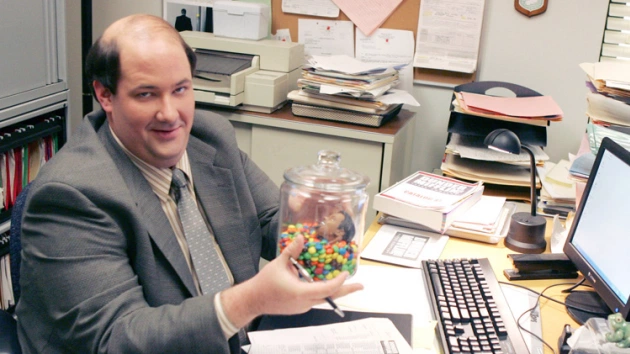

[Image source](https://www.lifeandstylemag.com/posts/brian-baumgartner-the-office-kevin-malone-voice-150929/)

## Motivation.

### What is your dataset?

The main dataset has been collected from [here](https://www.kaggle.com/sobhanmoosavi/us-accidents). Although, since the beginning of the project the version on there has been updated and it has been become unsuitable for us. That is why a [version 8](https://www.kaggle.com/sobhanmoosavi/us-accidents/version/8) has been used but as it is not possible to download older versions from Kaggle, it is available [here](https://drive.google.com/file/d/1BxiY1NjjimXG26mR6SH_jdchRh_efzuu/view?usp=sharing).

Another dataset has been put together by ourselves using data on U.S. DEPARTMENT OF TRANSPORTATION Federal Highway Administration [webpage](https://www.fhwa.dot.gov/policyinformation/travel_monitoring/tvt.cfm?fbclid=IwAR3RHvNbO9okcBFLD1-4gCz2JZezDDn2zV1D6GlTpI_0xc-mWyZjjFSYCAA). The final dataset can be accessed [here](https://drive.google.com/file/d/1x-FwmeoZKLokSC2lqe36sDv4do3WHe1R/view?usp=sharing).

### Why did you choose this/these particular dataset(s)?

A lot of traffic accidents are happening every day and to keep ourselves and other people more safe a data analysis on accidents can be conducted to get to know where the danger is hiding.

The first dataset with accidents and weather data was chosen as it was one of the most upvoted accidents dataset about US on [Kaggle](https://www.kaggle.com/) and it already included weather data. The second dataset with millions of miles driven in each month in each state was selected so that accident counts could be normalised and the relative danger would be comparable between different states.

### What was your goal for the end user's experience?

The goal was to get the better idea which places are more dangerous and if accidents would be predictable knowing weather data.

## Basic stats. Let's understand the dataset better

First we needed to see a good overview of the whole $1.5$ GB of the accidents dataset. For that a [Pandas Profiling](https://pandas-profiling.github.io/pandas-profiling/docs/master/rtd/) was used. As the dataset is big and with many columns it was not possible to use the full capabilities of `ProfileReport()` due to shortage of RAM and therefore a setting `minimal=True` was used, which excludes high demand calculations and does not require that much memory as it is explained [here](https://stackoverflow.com/questions/56035523/how-to-profile-large-datasets-with-pandas-profiling).

In [30]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
pd.options.mode.chained_assignment = None  # default='warn'

In [15]:
df = pd.read_csv('data/US_Accidents_Dec20.csv')

In [4]:
# NEEDS TO BE UNCOMMENTED WHEN PROFILER DOESN'T EXIST YET BUT CAN BE RE-COMMENTED LATER
#profile = ProfileReport(df, title="US accident data 2016-2020", html={'style': {'full_width': True}}, minimal=True)
#profile.to_file('data/pandas_profiling_raw_data.html')

Now there is really nice HTML overview in the `data` folder about the raw data from Kaggle named `pandas_profiling_raw_data.html`. It can also be seen when clicking on the three-dots-icon below.

In [5]:
from IPython.display import HTML
HTML(filename="data/pandas_profiling_raw_data.html")

Number of variables,49
Number of observations,4232541
Missing cells,14698523
Missing cells (%),7.1%
Duplicate rows,0
Duplicate rows (%),0.0%
Total size in memory,1.2 GiB
Average record size in memory,301.0 B
Categorical,22
Numeric,14
Boolean,13


### Write about your choices in data cleaning and preprocessing

There is actually quite a lot of information in the accidents dataset that we don't need. We will filter out only the columns that we find necessary (in the `features` variable)

In [16]:
features = ['Source', 'State', 'Start_Time', 'Severity', 
            'Start_Lng', 'Start_Lat', 'Humidity(%)', 'Pressure(in)', 'Temperature(F)', 
            'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 
            'Precipitation(in)', 'Weather_Condition']

In [17]:
df = df[features]

As we soon discovered, the author of the dataset suggests (discussion can be seen [here](https://www.kaggle.com/sobhanmoosavi/us-accidents/discussion/229412)) that Bing API was not a very stable source for data collection and he advises that MapQuest is more consistent. For that reason we only use data where `Source == MapQuest`. Luckily this is larger portion of the dataset. Afterwards we do not need the `Source` column anymore.

In [18]:
df = df.loc[df['Source'] == "MapQuest"]
df = df.drop(columns=['Source'])

Next up we need to make sure that our cleaned data is not some nonsense - outlier removal. From the previously generated HTML we can see the distributions of numerical attributes.

In [19]:
import matplotlib.pyplot as plt

### Data exploration

It would be interesting to investigate whether weather and location influences the severity of accidents or not. To this end, let's extract location and weather variables: longitude, latitude, temperature (in Fahrenheit), humidity percentage, pressure in inches Hg, visibility in miles, wind direction, wind speed (mph), precipitation in inches, and weather condition.

Before venturing into any machine learning project, it's always a good idea to check if the data looks reasonable. Let's start with a histogram plot of the variables we're going to use to see the distributions of the variables.

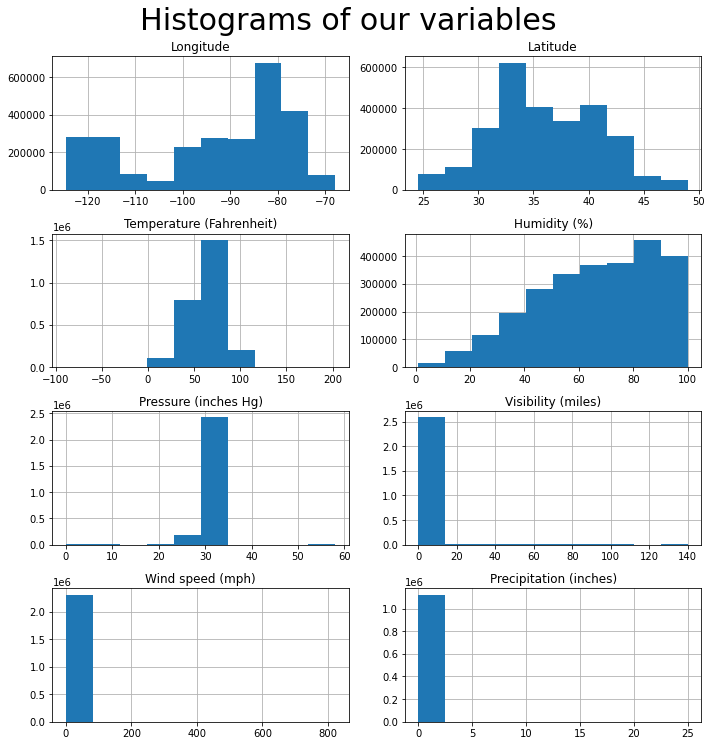

In [20]:
cols = ['Start_Lng','Start_Lat','Temperature(F)','Humidity(%)','Pressure(in)',
    'Visibility(mi)','Wind_Speed(mph)','Precipitation(in)']
cols_present = ['Longitude','Latitude','Temperature (Fahrenheit)','Humidity (%)', 
                'Pressure (inches Hg)', 'Visibility (miles)',
                   'Wind speed (mph)', 'Precipitation (inches)']
df_expl = df[cols]
df_expl.columns = cols_present

_ = df_expl.hist(column=df_expl.columns,figsize=(10,10),layout=(4,2),zorder=3)
plt.figtext(0.2,1,'Histograms of our variables',fontsize=30)
plt.tight_layout()

At first glance from this histogram plot, the data doesn't look too outlandish. However, there might be extreme outliers which aren't seen on the histogram plot. To investigate further, let's check out the boxplots of the variables.

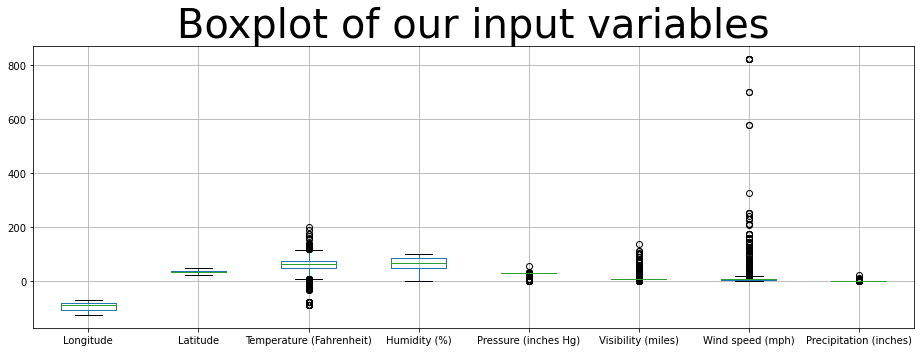

In [21]:
_ = df_expl.boxplot(figsize=(13,5),zorder=3)
_.set_title('Boxplot of our input variables',fontsize=40)
plt.tight_layout()

Whoa! What's going on with the wind speed?! We need to remove that plot and treat it separately. Let's plot the others again:

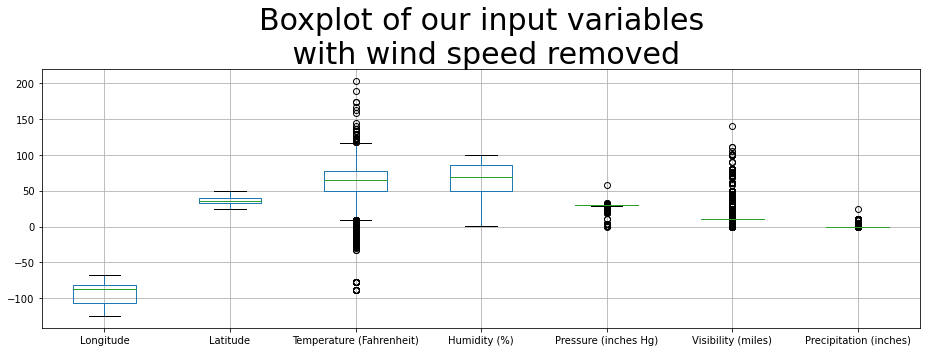

In [22]:
_ = df_expl.drop(columns='Wind speed (mph)').boxplot(figsize=(13,5),zorder=3)
_.set_title('Boxplot of our input variables\n with wind speed removed',fontsize=30)
plt.tight_layout()

The longitudes and latitudes appear reasonable still: The contiguous U.S. range from 25 to 50 in latitude, and the longitude ranges from -125 to -67. Nothing suspicious here.

Some observations have a very high temperature of over ~57°C! That can't be right. __[According to LiveScience magazine](https://www.livescience.com/30582-highest-hottest-temperature-recorded-us-world.html)__, the highest temperature recorded in the U.S. was 56.6°C in 1911. Clearly we need to toss out observations that have a temperature of over 130°F, or 57°C.

The low temperature outliers are a bit more tricky, because the most extreme temperatures are usually recorded at high mountaintops, which can't be extended to the ground where traffic is. So we'll have to be a bit more conservative with removing those outliers. We'll only toss out the bottom two.

Humidity looks good - it's measured in percentages, and they are between 0 and 100. In addition they seem to be primarily focused between the 50th-75th percents - which are also normal ranges for humidity percentage.

We need to be careful about the pressure, however, because standard air pressure at sea level is 29.9 inches, and the __[highest air pressure ever recorded](https://sciencing.com/range-barometric-pressure-5505227.html)__ is 32 inches, so there's not much room for extreme values. On the other end, the __[lowest air pressure ever recorded](https://guinnessworldrecords.com/world-records/lowest-barometric-pressure)__ was 25.6 inches.

The visibility looks a bit odd. According to __[this paper](https://www.biral.com/wp-content/uploads/2015/02/Introduction_to_visibility-v2-2.pdf)__, the visibility can extend up to around 18 miles, but many observations have the visibility at well over 50 miles. In addition, from the profiler we see that 77% of observations have the visibility at exactly 10 miles, which is suspect. 10 miles is probably a default or maximum value, so including this variable in our machine learning model will probably not be useful. We'll exclude it.

Next is precipitation. __[0.3 inches per hour](https://www.weathershack.com/static/ed-rain-measurement.html)__ is considered heavy rainfall, and the precipitation in this dataset is mostly well above that, so it's probably measured every 24 hours which, according to __[ThoughtCo](https://www.thoughtco.com/measuring-precipitation-1435346)__, is the most common time period of precipitation measurement in the United States. Therefore, precipitation looks normal.

Final item on the list is the crazy wind speed. Let's draw it up again, alone:

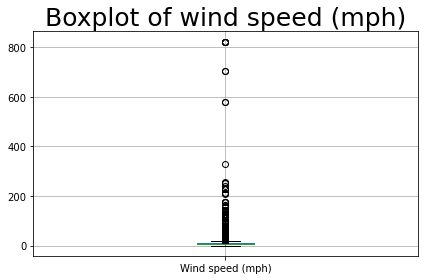

In [23]:
_ = df_expl.boxplot(column='Wind speed (mph)',zorder=3)
_.set_title('Boxplot of wind speed (mph)',fontsize=25)
plt.tight_layout()

We see some extreme values, but they could be due to hurricanes going over the area. The __[highest wind speed ever recorded in the U.S.](https://www.thoughtco.com/fast-wind-speed-recorded-3444498)__ was 231 mph, so anything above that is not within the realm of possibility.

__[Catastrophic damage will occur](https://www.nhc.noaa.gov/aboutsshws.php)__ for hurricanes of more than 157 mph. It's hard to believe that so many accidents occurred at the time that a hurricane equaling the worst in U.S. history was going over the area. Let's toss any above 200 mph out! 

Finally, let's check out the categorical variables like we promised.

In [24]:
df['Wind_Direction'].unique()

array(['Calm', 'SW', 'SSW', 'WSW', 'WNW', 'NW', 'West', 'NNW', 'NNE',
       'South', 'North', 'Variable', 'SE', 'SSE', 'ESE', 'East', 'NE',
       'ENE', 'E', 'W', nan, 'S', 'VAR', 'CALM', 'N'], dtype=object)

In [25]:
df['Weather_Condition'].unique()

array(['Light Rain', 'Overcast', 'Mostly Cloudy', 'Rain', 'Light Snow',
       'Haze', 'Scattered Clouds', 'Partly Cloudy', 'Clear', 'Snow',
       'Light Freezing Drizzle', 'Light Drizzle', 'Fog', 'Shallow Fog',
       'Heavy Rain', 'Light Freezing Rain', 'Cloudy', 'Drizzle', nan,
       'Light Rain Showers', 'Mist', 'Smoke', 'Patches of Fog',
       'Light Freezing Fog', 'Light Haze', 'Light Thunderstorms and Rain',
       'Thunderstorms and Rain', 'Fair', 'Volcanic Ash', 'Blowing Sand',
       'Blowing Dust / Windy', 'Widespread Dust', 'Fair / Windy',
       'Rain Showers', 'Mostly Cloudy / Windy', 'Light Rain / Windy',
       'Hail', 'Heavy Drizzle', 'Showers in the Vicinity', 'Thunderstorm',
       'Light Rain Shower', 'Light Rain with Thunder',
       'Partly Cloudy / Windy', 'Thunder in the Vicinity', 'T-Storm',
       'Heavy Thunderstorms and Rain', 'Thunder', 'Heavy T-Storm',
       'Funnel Cloud', 'Heavy T-Storm / Windy', 'Blowing Snow',
       'Light Thunderstorms and Snow',

The weather conditions look fine but there's something odd about the wind direction: there appear to be duplicate categories. We'll need to combine them.

Let's remove all those outliers, exclude the visibility, and remove those duplicate categories!

In [26]:
df_rm = df[(-50<df['Temperature(F)']) & (df['Temperature(F)']<130) &
          (26.5<df['Pressure(in)']) & (df['Pressure(in)']<32) & 
           (df['Wind_Speed(mph)']<200)]

to_replace = ['West','South','North','Variable','East','Calm']
values = ['W','S','N','VAR','E','CALM']
df_rm['Wind_Direction'] = df_rm['Wind_Direction'].replace(to_replace,values)

features.remove('Visibility(mi)')

In [27]:
df = df_rm.drop(columns=['Visibility(mi)'])

Lastly we write the cleaned dataset into a new file because loading the whole big dataset in every time we want to work with the data and do those steps again is tedious and time-consuming. This cleaned dataset is also available [here](https://drive.google.com/file/d/1YrUfQyMW7pbsGx907Zpkocxfr0y4IrrM/view?usp=sharing).

In [ ]:
# NEEDS ONE SUCCESSFUL RUN ONLY
#df.to_csv('data/cleaned_data.csv', index=False)

### Write a short section that discusses the dataset stats, containing key points/plots from your exploratory data analysis.

For that another profiler can be run with full capabilities of Pandas Profiler because the dataset is now smaller and with a lot fewer columns.

In [ ]:
# NEEDS TO BE UNCOMMENTED WHEN PROFILER DOESN'T EXIST YET BUT CAN BE RE-COMMENTED LATER
#df = pd.read_csv('data/cleaned_data.csv')
#profile = ProfileReport(df, title="US accident data 2016-2020 cleaned", html={'style': {'full_width': True}})
#profile.to_file('data/pandas_profiling_cleaned_data.html')

Now there is a nice HTML overview in the `data` folder about the cleaned data too named `pandas_profiling_cleaned_data.html`. Unfortunately it couldn't be loaded into notebook due to some encoding errors.

In [55]:
#HTML(filename="data/pandas_profiling_cleaned_data.html")

Now we can see that the distributions are much nicer. We can also see the correlations between attributes. The different correlations tables indicate that there might be some small correlation between `Severity` and some weather attributes like pressure and percipitation.

## Data Analysis

### Describe your data analysis and explain what you've learned about the dataset.

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Let's first read in the cleaned dataset.

In [71]:
df = pd.read_csv('data/cleaned_data.csv')

Let's also read in the dataset of vehicle miles (millions) to normalise our accidents data. Let's call the unit Millions of Miles Driven (MMD) from now on. And let's save the dictionary of `State Abbrevations` to `State Name` for future purpouses.

In [72]:
df_miles = pd.read_csv('data/VehicleMiles_FEB2016_DEC2020.xlsx - Sheet1.csv').set_index('State Abbrevations')
df_miles = df_miles.sort_index()

state_abb_dict = df_miles['State Name'].to_dict()
df_miles = df_miles.drop(columns=['State Name'])

Now we would need to merge them together. For that we need to group the data by `State` and `Year`-`Month`.

In [73]:
df['Start_Time_dt'] = pd.to_datetime(df['Start_Time'], format='%Y-%m-%d %H:%M:%S')

In [74]:
states_monthly = df.groupby([df['State'], df['Start_Time_dt'].dt.year, df['Start_Time_dt'].dt.month]).count()['Start_Time']
states_monthly = states_monthly.unstack(level=0).T.sort_index()

We need to check if the shapes are matching.

In [75]:
print("Accidents data has a shape of: ", states_monthly.shape)
print("Driven miles data has a shape of: ", df_miles.shape)

Accidents data has a shape of:  (49, 59)
Driven miles data has a shape of:  (51, 59)


This means that there are 2 states less in the accidents dataset. Let's keep only the part that is the same.

In [76]:
df_miles = df_miles.loc[states_monthly.index]
print("Driven miles data has a shape of: ", df_miles.shape)

Driven miles data has a shape of:  (49, 59)


Now let's make sure they have same indices and column names.

In [77]:
states_monthly = states_monthly.fillna(0)
states_monthly = states_monthly.astype('int32')
states_monthly.columns = df_miles.columns

Next we can do the normalising - number of Accidents per Millions of Miles Driven (AMMD). And see the results in a form of heatmap (each row has its own colorscale). Although for the colors to be seen the notebook has to be ran (but it doesn't matter that much anyway).

In [78]:
acc_per_mil_miles = states_monthly.div(df_miles)
acc_per_mil_miles.style.background_gradient(cmap='Blues', axis=1)

,Feb-16,Mar-16,Apr-16,May-16,Jun-16,Jul-16,Aug-16,Sep-16,Oct-16,Nov-16,Dec-16,Jan-17,Feb-17,Mar-17,Apr-17,May-17,Jun-17,Jul-17,Aug-17,Sep-17,Oct-17,Nov-17,Dec-17,Jan-18,Feb-18,Mar-18,Apr-18,May-18,Jun-18,Jul-18,Aug-18,Sep-18,Oct-18,Nov-18,Dec-18,Jan-19,Feb-19,Mar-19,Apr-19,May-19,Jun-19,Jul-19,Aug-19,Sep-19,Oct-19,Nov-19,Dec-19,Jan-20,Feb-20,Mar-20,Apr-20,May-20,Jun-20,Jul-20,Aug-20,Sep-20,Oct-20,Nov-20,Dec-20
State,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AL,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000159,0.000327,0.007989,0.087672,0.084333,0.060859,0.053783,0.099048,0.129975,0.130251,0.174563,0.157364,0.168719,0.150481,0.123178,0.181961,0.224091,0.254935,0.296504,0.265937,0.275028,0.277952,0.286968,0.258346,0.241993,0.229229,0.222009,0.199351,0.231642,0.309524,0.279747,0.232911,0.272759,0.274219,0.210402,0.148708,0.159281,0.184683,0.187349,0.191821,0.214337,0.237388,0.268188,0.239773
AR,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000632,0.005394,0.005541,0.005737,0.003207,0.004119,0.002939,0.009170,0.002600,0.006750,0.005210,0.004296,0.004263,0.007386,0.007394,0.006800,0.007291,0.005173,0.003490,0.007951,0.002641,0.004020,0.005990,0.002177,0.002653,0.002877,0.003929,0.003645,0.003666,0.003883,0.002124,0.003961,0.004464,0.003153,0.002971,0.003195,0.003941,0.011081,0.024390,0.020226,0.021166,0.012310
AZ,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.042259,0.369739,0.396985,0.284644,0.324746,0.240889,0.313976,0.251907,0.221196,0.213248,0.258857,0.219014,0.261046,0.409490,0.322726,0.285283,0.358998,0.255622,0.299759,0.273993,0.278901,0.247870,0.256556,0.268859,0.354606,0.458055,0.436203,0.376494,0.360542,0.246640,0.272984,0.274440,0.234674,0.239859,0.212324,0.201901,0.208424,0.174881,0.154213,0.175728,0.228210,0.171234
CA,0.000000,0.108869,0.347451,0.304856,0.349173,0.311975,0.400174,0.438426,0.363362,0.394743,0.340694,0.451723,0.437792,0.380200,0.359293,0.252307,0.302412,0.258975,0.301476,0.367044,0.306859,0.274671,0.245844,0.336728,0.339478,0.393635,0.344189,0.370449,0.323388,0.336741,0.391273,0.435347,0.338068,0.303092,0.097238,0.365370,0.364096,0.324151,0.283365,0.339220,0.272918,0.239793,0.227404,0.153104,0.145004,0.226713,0.163698,0.153369,0.167928,0.149906,0.140247,0.118019,0.121517,0.186621,0.227120,0.263100,0.246416,0.258206,0.218759
CO,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022615,0.215360,0.220045,0.219319,0.200543,0.180959,0.185443,0.242957,0.167128,0.172929,0.211714,0.182169,0.147354,0.191732,0.223844,0.179014,0.226674,0.156586,0.249522,0.214661,0.172620,0.191556,0.228799,0.183847,0.193988,0.205209,0.181016,0.241379,0.288901,0.183041,0.167816,0.280391,0.166213,0.149438,0.106709,0.146532,0.147156,0.129761,0.152661,0.130807,0.127308,0.116098
CT,0.000000,0.000000,0.000000,0.000000,0.041237,0.090529,0.105355,0.121336,0.117523,0.167905,0.131682,0.124593,0.143360,0.144003,0.102684,0.079849,0.124694,0.114616,0.131239,0.141436,0.167947,0.183540,0.146208,0.166102,0.168513,0.141505,0.159920,0.131203,0.139368,0.120690,0.120813,0.126990,0.139567,0.141943,0.122155,0.130711,0.134686,0.125947,0.105854,0.096930,0.114137,0.098563,0.103251,0.112765,0.143506,0.160363,0.145662,0.126866,0.100138,0.096143,0.121547,0.075042,0.072125,0.079022,0.077391,0.091096,0.117624,0.098448,0.100140
DC,0.000000,0.000000,0.000000,0.000000,0.032258,0.145374,0.121547,0.088146,0.132450,0.245487,0.243333,0.199346,0.310680,0.165541,0.135135,0.116438,0.116279,0.132743,0.137741,0.100890,0.000000,0.048611,0.137380,0.074586,0.183673,0.154639,0.140575,0.139818,0.114458,0.101626,0.128834,0.100000,0.103746,0.126712,0.127796

So we see already that there is something fishy but let's start from the beginning.

We wanted to see what is the normalised accidents distribution between states. For that all the accidents for a single state have to be summed and then all the miles and then they have to be divided to get the average AMMD.

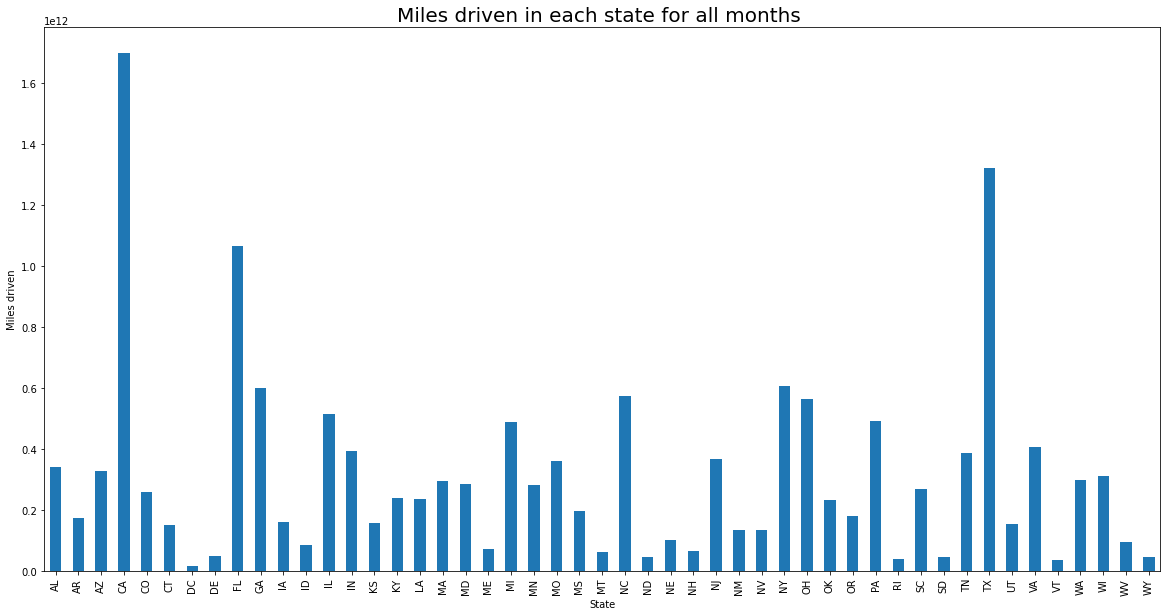

In [12]:
miles_total = df_miles.sum(axis=1)
ax = (miles_total*1e6).plot(kind="bar", figsize=(20,10))
_ = ax.set_ylabel('Miles driven')
_ = ax.set_title('Miles driven in each state for all months ',fontsize = 20)

It can be seen that states such as Texas and California (rank 1 and 2 in area, respectively, of the 49 states presented) have driven the most miles. (Note: Notice the scale of the y-axis) 

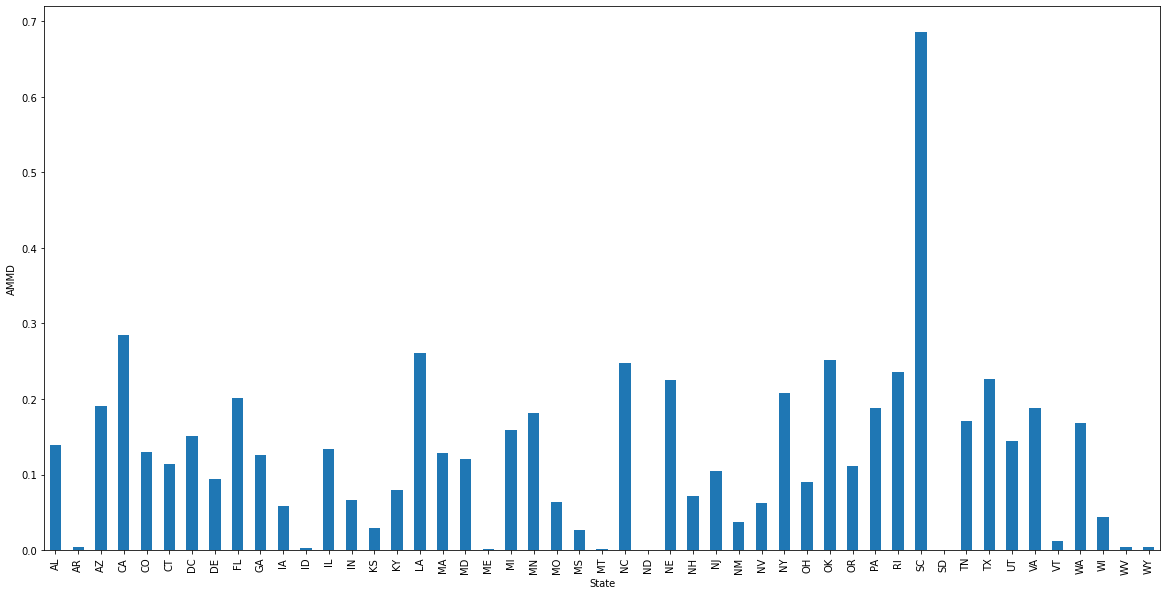

In [13]:

acc_total = states_monthly.sum(axis=1)

ax = (acc_total/miles_total).plot(kind="bar", figsize=(20,10))
_ = ax.set_ylabel('AMMD')

South Carolina has weirdly high AMMD. As AMMD has often quite low values and are hard to grasp let's from now on use unit ABMD (number of Accidents per Billions of Miles Driven).

Let's see how the `Severity` is distributed for each state in such scale.

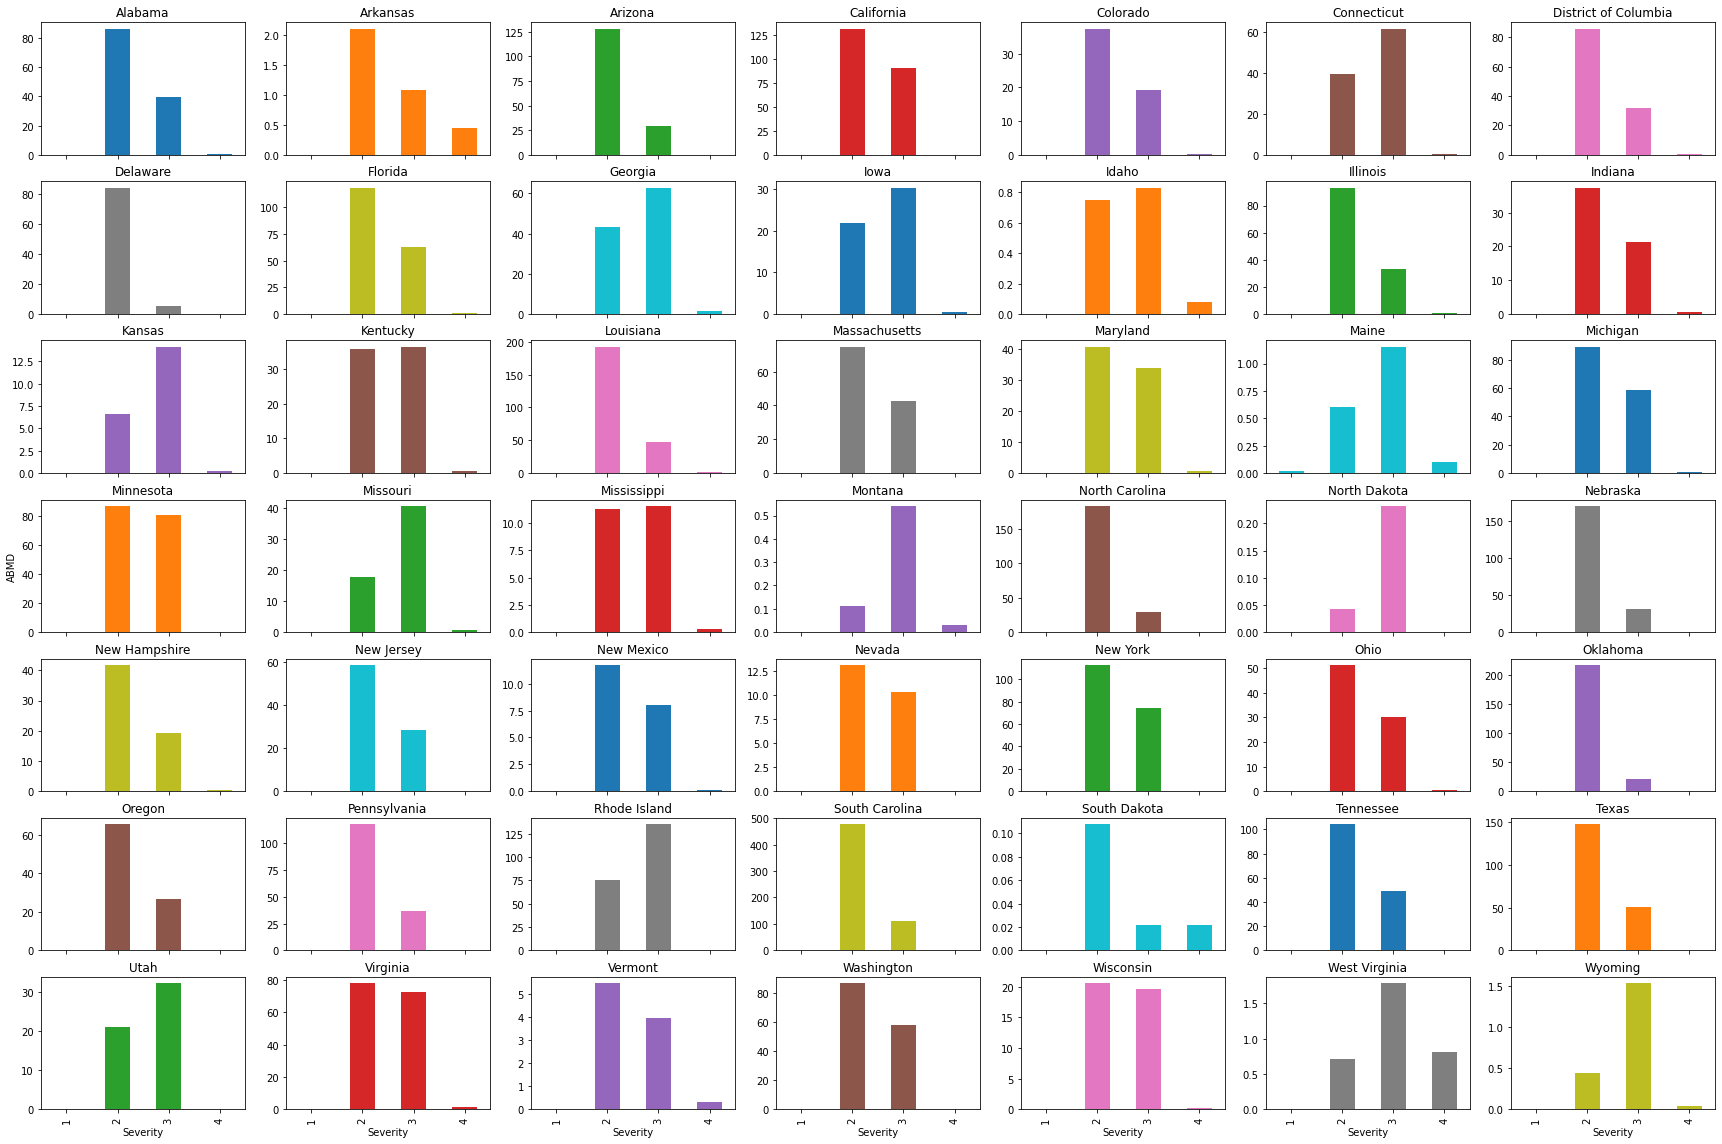

In [80]:
states_sev = df.groupby(['State', 'Severity']).count()['Start_Time'].unstack(level=-1)
states_sev = (states_sev.T/miles_total)#.drop(columns=['SC'])

# For nice state names
state_names = [state_abb_dict[x] for x in df_miles.index]

#states_sev
ax = (states_sev*1000).plot(kind="bar", subplots=True, layout=(7, 7), title=state_names, legend=None, figsize=(30,20))
_ = ax[3, 0].set_ylabel('ABMD')

It is easily seen that most likely in most of the states a driver can end up in a `Severity` 2 or 3 type of accident. But when comparing them state-to-state then pay attention to the y-scales.

The previously displayed heatmap is not really the best way of showing that data. It would be much more convenient for a viewer to see it in a choropleth map. So let's do that. Colorscale shows ABMD.

In [81]:
import plotly.express as px

In [82]:
def draw_map_from_heatmap(df, label='color', html = 'filename', static_colorscale=True):
    if static_colorscale:
        fig = px.choropleth(data_frame=df, 
                            locations=df.index.get_level_values(0), 
                            color=df,  
                            locationmode="USA-states", 
                            scope="usa", 
                            animation_frame=df.index.get_level_values(1), 
                            range_color=(0, df.max()), 
                            labels={'color':label})
        fig.write_html(html)
    else:
        fig = px.choropleth(data_frame=df, 
                            locations=df.index.get_level_values(0), 
                            color=df,  
                            locationmode="USA-states", 
                            scope="usa", 
                            animation_frame=df.index.get_level_values(1), 
                            labels={'color':label})
    fig.show()

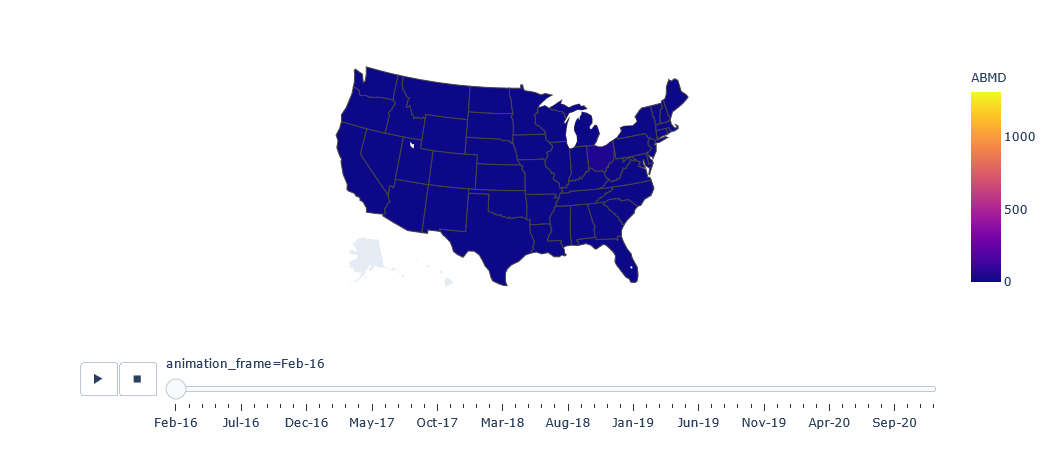

In [83]:
draw_map_from_heatmap(1000*acc_per_mil_miles.stack(), label='ABMD',html='ABMD.html')

Several times the graph changes really drastically and suddenly (Jul-17 to Aug-17; May-18 to Jun-18; etc.) which is a little unexpected. To explain that two similar map animations are made for the number of accidents and Billions of Miles Driven (BMD).

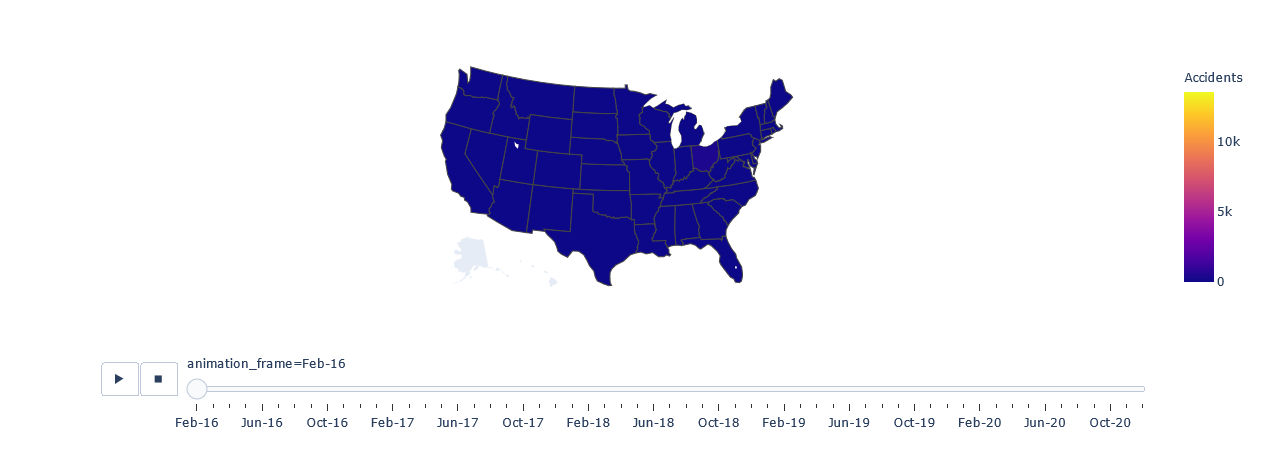

In [84]:
draw_map_from_heatmap(states_monthly.stack(), label='Accidents',html='accidents.html')

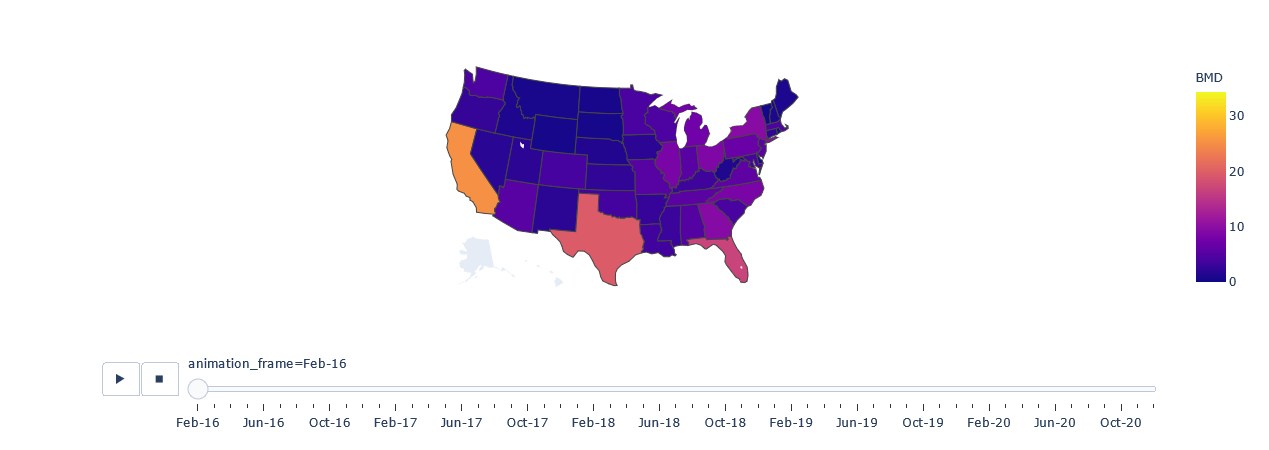

In [85]:
draw_map_from_heatmap((df_miles/1000).stack(), label='BMD',html='BMD.html')

These views give a good intuition of how consistent each data collection is. There seems to be way more sudden changes within the accidents data. This can also be argued that MMD data has been collected from a governmental institution's webpage. Whereas accidents data has been collected via API that potentially has variations in traffic throughout time. Although the author of the dataset commented that MapQuest has shown more stability ([here](https://www.kaggle.com/sobhanmoosavi/us-accidents/discussion/229412)) it still seems that it has not been consistent enough.

### If relevant, talk about your machine-learning.

In [51]:
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import confusion_matrix, f1_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import seaborn as sbn

Based on the data exploration above, we are only using a subset of the columns as input in our model:

In [34]:
features = list(set(features) - set(['Source','State','Start_Time','Severity']))
target = 'Severity'

Some functions we will need

In [62]:
def get_dummies(X, impute_idx):
    for idx in impute_idx:
        idx = str(idx)
        classes = pd.Series(X[idx].unique()).sort_values()
        # We don't want a column that is classname_<NA>
        # From index 1, instead of 0, to drop the first class
        # to avoid the dummy variable trap.
        # Equivalent to "drop_first=True" in Pandas' implementation
        for class_ in classes[1:]:
            class_name = idx + '_' + str(class_)
            X[class_name] = np.where(X[idx] == class_, 1, 0)

    return X.drop(columns=impute_idx)

def train_test(df, features=features, target='Severity'):

    # Drop NA values from categorical variables
    types = df.dtypes
    categorical = [col for col in features if types[col]!=np.float64]
    df = df.dropna(subset=categorical)
    
    X = df[features]; y = df[target]

    # One-hot encode categorical variables
    X = get_dummies(X,categorical)

    # X_train, X_test, y_train, y_test
    return train_test_split(X,y,test_size=0.2)

def impute(X_train, X_test, y_train, y_test):
    impute = KNNImputer(missing_values=np.nan)
    types = X_train.dtypes
    impute_cols = [col for col in X_train.columns if types[col]==np.float64]
    impute_cols.remove('Start_Lng'); impute_cols.remove('Start_Lat')
    
    # Impute training set
    X_train[impute_cols] = impute.fit_transform(X_train[impute_cols])

    # Impute test set
    X_test[impute_cols] = impute.fit_transform(X_test[impute_cols])
    
    return X_train, X_test, y_train, y_test
    
def gridsearch(X_train, y_train):
    # Define classifier
    weights = {0:20,1:5,2:5,3:20}
    ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10,
                                                   min_samples_leaf=20))
    # Parameter grid
    learning_rate = np.logspace(-8,1,100)
    param_grid_ada = {'learning_rate':learning_rate}

    # Fit model
    cv = KFold(n_splits=5,shuffle=True,random_state=1)
    grid = GridSearchCV(ada,n_jobs=-1,param_grid=param_grid_ada,
                        scoring='f1_weighted',cv=cv,return_train_score=True)

    grid.fit(X_train,y_train)
    
    return grid

def plot_grid(x,scores):
    # scores[0] is train scores
    # scores[1] is test scores
    plt.semilogx(x,scores[0])
    plt.semilogx(x,scores[1])
    plt.legend(['Train F1-score','Test F1-score'])
    plt.xlabel('Learning rate',fontsize=20)
    plt.ylabel('F1 score',fontsize=20)
    plt.title(f'F1 score as a function of learning rate \n',fontsize=20)
    
def plot(confusion_matrix, scores=None, cv=True):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    labels=range(1,5)
    _ = sbn.heatmap(confusion_matrix,
                     annot=True,fmt=',d',xticklabels=labels,yticklabels=labels)
    _.set_title('Confusion matrix for accident severities',fontsize=20)
    _.set_xlabel('Predicted class',fontsize=15)
    _.set_ylabel('True class',fontsize=15)
    
    if cv:
        plt.subplot(1,2,2)
        plot_grid(np.logspace(-8,1,100),
                  [scores[0],
                   scores[1]])
    plt.show()

#### Balanced training set

Let's check out the distribution of the four classes.

In [36]:
print('Class distribution for accident severity')
counts = df['Severity'].value_counts().sort_index()
counts

Class distribution for accident severity


1        946
2    1505417
3     745877
4       8267
Name: Severity, dtype: int64

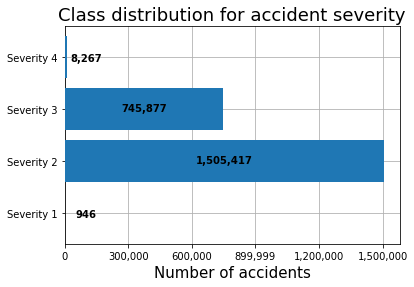

In [37]:
graph = plt.barh([f'Severity {i}' for i in range(1,5)],counts,zorder=3)

plt.title('Class distribution for accident severity',fontsize=18)
plt.xlabel('Number of accidents',fontsize=15)
plt.xticks([int(i*1e6) for i in np.linspace(0,1.5,6)], [f'{int(i*1e6):,}' for i in np.linspace(0,1.5,6)])
plt.grid(True)

i = 0
for bar in graph:
    width = bar.get_width()
    height = bar.get_height()
    x, y = bar.get_xy()
    if i==0 or i==3:
        plt.text(x+1e5,
             y+height*0.4,
             f'{counts.iloc[i]:,}',
             ha='center',
             weight='bold')
    else:
        plt.text(x+width/2,
                 y+height*0.45,
                 f'{counts.iloc[i]:,}',
                 ha='center',
                 weight='bold')
    i+=1
plt.show()

We can see that there's a lot of data, but there is a huge class imbalance. Many machine learning algorithms don't deal well with imbalanced classes; Let's try to undersample the large classes so that we can get a balanced dataset. That is, we're going to randomly delete rows in the dataset which belong to the large classes until we obtain a dataset which has an equal number of rows belonging to each class.

The undersampling takes a long time for the entire dataset, so we're going to write the data to a .csv file for easy import later. To treat missing values, we will use imputation for the real values, and for missing values for categorical variables, we will simply drop the rows. Since Decision Tree classifiers aren't affected by different scales in the data, we didn't normalize it.

To measure the performance of our model, we will use F1-scoring. It is a trade-off between precision:

$$\frac{\text{true positives}}{\text{true positives + false positives}}$$ 

and recall: 

$$\frac{\text{true positives}}{\text{true positives + false negatives}}.$$

It's useful in cases where there is class imbalance. We will use it in both the balanced and the unbalanced case, to compare the values.

In [44]:
X_train, X_test, y_train, y_test = train_test(df)

# Balance classes in training set
ros = RandomUnderSampler(random_state=0)
X_train, y_train = ros.fit_resample(X_train, y_train)
print(f'Balanced classes: {y_train.value_counts().values}')

df_train = pd.concat([X_train,y_train],axis=1)
df_test = pd.concat([X_test,y_test],axis=1)
df_train.to_csv('Xy_train.csv',index=False)
df_test.to_csv('Xy_test.csv',index=False)

Balanced classes: [743 743 743 743]


In [45]:
df_train = pd.read_csv('Xy_train.csv')
df_test = pd.read_csv('Xy_test.csv').dropna()
X_train, y_train = df_train.drop(columns=['Severity']), df_train.Severity
X_test, y_test = df_test.drop(columns=['Severity']), df_test.Severity

X_train, X_test, y_train, y_test = impute(X_train, X_test, y_train, y_test)

We're going to use an AdaBoost classifier using a decision tree classifier. Decision tree classifiers are particularly interpretable, although they suffer from high variance, and the tree structure can change completely when new data is added. However, the AdaBoost classifier will run many decision trees and slightly tweak them in favor of instances misclassified by previous trees. Therefore, AdaBoost does well on imbalanced datasets. We'll use it on the balanced dataset as well, since it doesn't do particularly poorly on balanced datasets either.

For the decision trees inside AdaBoost, we'll use max_depth=10, so the maximum depth of the tree is 10 nodes. We will in addition set the minimum samples per leaf to 20. This will effectively help prevent overfitting.

AdaBoost with decision trees is considered the best out-of-the-box classifier. (__[Source](https://en.wikipedia.org/wiki/AdaBoost)__)

We will use a grid search to find the optimal value of the hyperparameter, which is learning rate for the AdaBoost classifier. Outside the grid search, we apply 5-fold cross-validation for model validation.

In [48]:
balanced_grid = gridsearch(X_train, y_train)

In [49]:
y_pred = balanced_grid.predict(X_test)

# Metrics
balanced_results = pd.DataFrame(balanced_grid.cv_results_)

print('Best result of cross-validation:')
print(balanced_results[balanced_results
                   .rank_test_score==1][['param_learning_rate','mean_train_score','mean_test_score']]
      .round(decimals=2))

print(f'\nF1-score:\t{f1_score(y_test,y_pred,average="weighted"):.2}')

Best result of cross-validation:
   param_learning_rate  mean_train_score  mean_test_score
71             0.02848              0.73             0.39

F1-score:	0.4


Above we see that our best score is 0.4. Since it's four classes we're predicting, it's above a random guess, but still not very good.

To visualize our performance, we're going to firstly use a confusion matrix. A confusion matrix is a classification measurement of how well our model did at predicting the classes for the test inputs. The vertical axis of the confusion matrix denotes the true, or actual, class, and the horizontal matrix denotes the predicted class. So the number inside the cell in row 1, column 2, means the number of times that the model predicted class (severity) 2, when the true class was severity 1.

The second measurement we're going to use is a plot of the score of all the models we tested. When we were tuning the settings of our model, we trained it over and over with the settings of our model tweaked slightly; and we did that a hundred times in the interval from 1e-8 to 1.

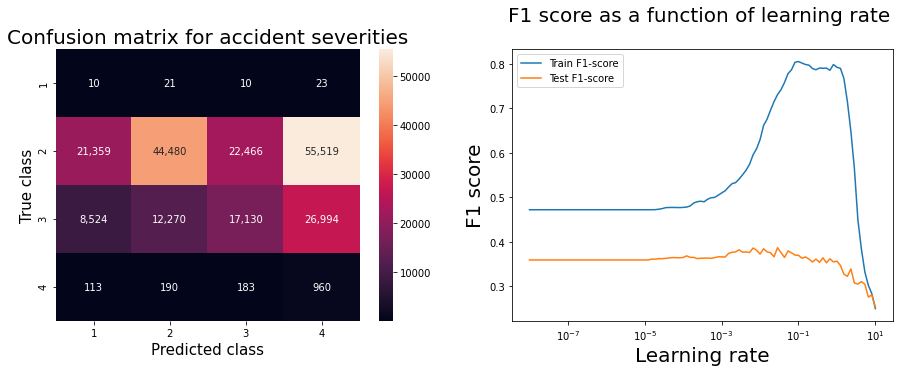

In [63]:
plot(confusion_matrix(y_test,y_pred), 
     [balanced_results.mean_train_score,
      balanced_results.mean_test_score])

Our classifier is atrocious. There is a big gap between train and test set performance, and in order to increase the test set performance, we need to substantially increase the train performance. This indicates a great deal of overfitting.

From the confusion matrix we can see that the model is doing a very poor job at predicting the classes. A substantial amount of the predictions fall outside of the diagonal (i.e. incorrect predictions).

Back to the drawing board!

#### Unbalanced training set

Woops, this didn't give a desired result! Perhaps the issue is that we balanced the training set? Let's see what happens if we leave the training set unbalanced. This would probably mean that our model will have a hard time predicting the minority classes, but at least we might get a good accuracy for the majority classes.

Since we have a large amount of data, we're going to aggressively drop any rows which have missing values in columns we care about:

In [58]:
df_sample = df.dropna(subset=features)#.sample(100000)

In [59]:
df_dropped = df.dropna(subset=features)

In [54]:
X_train2, X_test2, y_train2, y_test2 = train_test(df_dropped)

We've already found a good value for the learning rate through cross-validation on the balanced dataset, so we'll use that again here. That way, we don't need to use cross-validation again.

In [55]:
ada = AdaBoostClassifier(learning_rate=0.015,
                         base_estimator=DecisionTreeClassifier(max_depth=10,min_samples_leaf=20))
fit = ada.fit(X_train2,y_train2)

F1-score on train set:	0.78
F1-score on test set:	0.77


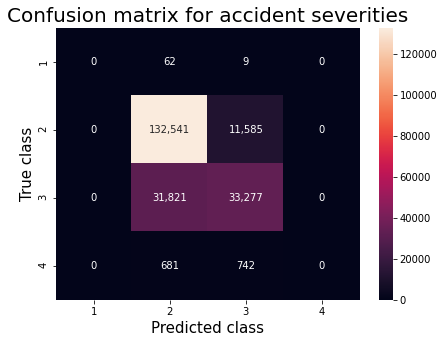

In [64]:
y_pred2 = fit.predict(X_test2)
y_pred2_train = fit.predict(X_train2)

print(f'F1-score on train set:\t{f1_score(y_train2,y_pred2_train,average="weighted"):.2}')
print(f'F1-score on test set:\t{f1_score(y_test2,y_pred2,average="weighted"):.2}')

plot(confusion_matrix(y_test2,y_pred2),cv=False)

We got an F1-score of 0.77! Compared to the F1-score of 0.38 with the balanced dataset, this is a massive improvement.

The maximum score is 1, so this looks much better! From the confusion matrix we see that severities 1 and 4 don't do so well, which is expected, since there were so few of those classes in the training set. We also see from the scores above for the train and test sets that we probably aren't overfitting, since the gap between the train and test scores is pretty small.

One more thing: the model we used has a neat feature which allows us to see how important all the input variables are for the prediction of the output classes. The weather conditions and wind directions were one-hot encoded, so if we want to find the variable importance, we need to sum up all the one-hot encoded columns for those variables.

In [57]:
feature_importances = pd.Series(ada.feature_importances_,index=X_train2.columns)
Weather_ = (feature_importances[[col for col in X_train2.columns if 'Weather_' in col]]
            .sum())
Wind_Direction_ = (feature_importances[[col for col in X_train2.columns if 'Wind_D' in col]]
            .sum())

Let's plot the variable importance with a horizontal bar chart.

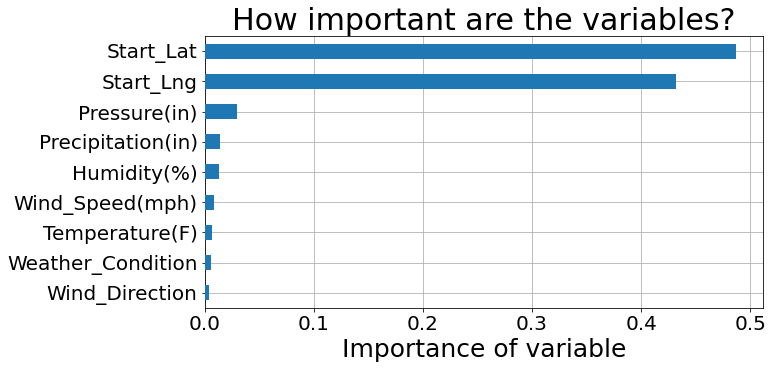

In [58]:
sans_ohe = feature_importances[[col for col in X_train2.columns 
                                if 'Weather_' not in col and 'Wind_D' not in col]]
sans_ohe['Weather_Condition'] = Weather_
sans_ohe['Wind_Direction'] = Wind_Direction_
sans_ohe.columns = ['Longitude','Latitude','Humidity (%)', 'Pressure (inches Hg)', 'Visibility (miles)',
                   'Wind speed (mph)', 'Precipitation (inches)', 'Weather condition', 'Wind direction']

_ = (sans_ohe.T.sort_values().plot(kind='barh',rot=0,figsize=(10,5),fontsize=20,grid=True,
                     sort_columns='ascending',legend=False,zorder=3))
_.set_title('How important are the variables?',fontsize=30)
_.set_xlabel('Importance of variable',fontsize=25)
plt.show()

What we can see here is that the location (longitude, latitude) accounts for most of the prediction. However, the feature importances presented here don't have to add up to 1. It makes sense that location would be the strongest predictor; in some places, the road conditions are such that there is a higher chance of a serious car accident.

What's surprising is that weather condition has very little effect on the prediction.

We also didn't expect pressure to be the most significant of the weather variables. It could be that increased air pressure is directly caused by something else in the atmosphere, and it's that latent variable which really increases the severity of accidents.

## Genre. Which genre of data story did you use?

We mainly followed the magazine type genre but the plots and interactive parts within it can also be described as annotated plots or animation.

### Which tools did you use from each of the 3 categories of Visual Narrative (Figure 7 in Segal and Heer). Why?

From Visual Structuring we used:

* Consistent Visual Platform (everything hapens on same page mainly)

* Progress Bar (webpage has scrollbar)

From Highlighting we used:

* Feature Distinction (outliers in bar chart)

* Zooming (within the choropleth maps)

From Transition Guidance we used:

* Familiar Objects (Several similar graph types)

### Which tools did you use from each of the 3 categories of Narrative Structure (Figure 7 in Segal and Heer). Why?

From Ordering we used:

* Linear (scrolling down on the page)

From Interactivity we used:

* Hover Highlighting / Details (choropleth map has that option)

* Navigation Buttons (Pandas profiler results has that option)

* Explicit Instruction

From Messaging we used:

* Captions / Headlines (on webpage itself)

* Annotations (7x7 graph of severities has state names, choropleth shows state names when hoovering, etc.)

* Accompanying Article (links to different sources)

* Multi-Messaging (supporting text with relevent highlights on graphs)

* Introductory Text (right at the beginning)

* Summary (the conclusions part at the end)

## Visualizations.

### Explain the visualizations you've chosen.

* Interactive HTMLs of pandas profilers are included because the easily and almost automatically generated report is very informative and has relevant plots in it.

* Boxplots with outliers describe really well the outliers (they technically can be found within pandas profiling too but have them together visually is much better)

* Bar plots describe well the differences that several states/severities/attributes have compared to each other.

* Choropleths describe well the spacial distributions.

* Confusion matrices are good to describe a predicting algorithm.

### Why are they right for the story you want to tell?

* As dealing with the US data it's nice to have the choropleth instead of just having different state names next to each other and not knowing where they are located compared to other states.

* Then again bar charts give better comparison than the colorscale on map.

* Boxplot shows that data is not that pretty. And gives a good idea how trustworthy the data is.

* How else do you give a quick and small overview of a predicting algorithm if not confusion matrix?

## Discussion. Think critically about your creation

### What went well?,

We sucessfully combined two datasets to see the accidents probabilities (how likely one is to end up in an accident according to how much they drive) in each US state and used several ways and time periods to show that info.

We successfully trained a machine learning model to predict a accident's severety knowing its location and some weather data.

### What is still missing? What could be improved?, Why?

The trustworthiness is questionable about the AMMD as it shows high fluctuations throughout time. It would require to collect accidents data some other way or find a better source. There probably is not a  better way to normalise the amount of accidents besides miles driven data so this cannot be improved but there might be some better way of visualising it that we didn't think of.

Learning algorithm could also be improved if collected data would have more accurate and trustworthy source. As we saw there were quite some outliers for weather data and we cannot be entierly sure how accurate are other measurements. Maybe with more percise data a more accurate prediction algorithm could be madea and then it might not need a location data. Also some other learning algorithm might be considered.

The algorithm did very poorly on the minority classes, i.e. severities 1 and 4. What we tried, which was simply balancing the classes in the training data, didn't work. Improvements could be researching other machine learning algorithms which fare better with such an extreme class imbalance. However, this classification is inherently difficult; with 1000 observations belonging to the smallest class, and 1.5 million to the largest.

## Contributions. Who did what?

### You should write (just briefly) which group member was the main responsible for which elements of the assignment. (I want you guys to understand every part of the assignment, but usually there is someone who took lead role on certain portions of the work. That's what you should explain).

WHO | WHAT

**Kristo** | Preprocessing of data and describing data analysis

**Gudmundur**  | Outlier analysis and machine learning

**Edin** | Generating and finalizing site using Hugo

## Make sure that you use references when they're needed and follow academic standards.

The relevant hyperlinks are inserted within text itself.